In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hiteshraa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation


100%|██████████| 83.7M/83.7M [00:00<00:00, 123MB/s] 


In [2]:
import glob, json
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import os
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
train_path = "/content/brain-tumor-image-dataset-semantic-segmentation/train"
test_path = "/content/brain-tumor-image-dataset-semantic-segmentation/test"
valid_path = "/content/brain-tumor-image-dataset-semantic-segmentation/valid"

In [4]:
train_data = [image for image in os.listdir(train_path)]
test_data = [image for image in os.listdir(test_path)]
valid_data = [image for image in os.listdir(valid_path)]

In [5]:
len(train_data), len(test_data), len(valid_data)

(1503, 216, 430)

In [6]:
train_annotation = glob.glob(os.path.join(train_path, '*.json'))
test_annotation = glob.glob(os.path.join(test_path, '*.json'))
valid_annotation = glob.glob(os.path.join(valid_path, "*.json"))

In [7]:
train_annotation[0]

'/content/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json'

In [8]:
train_annotation = json.load(open(train_annotation[0]))
test_annotation = json.load(open(test_annotation[0]))
valid_annotation = json.load(open(valid_annotation[0]))

In [9]:
len(train_annotation), len(test_annotation), len(valid_annotation)

(5, 5, 5)

In [10]:
len(train_annotation['images']), len(train_annotation['annotations'])

(1502, 1502)

In [11]:
train_annotation['images'][0]

{'id': 0,
 'license': 1,
 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2023-08-19T04:37:54+00:00'}

In [12]:
train_annotation['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 1,
 'bbox': [145, 239, 168.75, 162.5],
 'area': 27421.875,
 'segmentation': [[313.75,
   238.75,
   145,
   238.75,
   145,
   401.25,
   313.75,
   401.25,
   313.75,
   238.75]],
 'iscrowd': 0}

In [13]:
# Function to visualize random images
def visualize_random_images(n=3):
    indices = np.random.randint(0, len(train_annotation['images']), size=n)

    # Image and Annotation Retrieval:
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img, ann in zip(images, annotations):
        # Load the image using file name from annotation
        image_path = os.path.join(train_path, img['file_name'])
        image = cv2.imread(image_path)

        if image is None:
            print(f"Image not found or failed to load: {image_path}")
            continue

        # Convert image from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(n, 3, j)
        plt.imshow(image)
        j += 1

        # Create masked images from annotations
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)

        # Draw polylines on the image (green color with thickness 2)
        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)

        plt.subplot(n, 3, j)
        plt.imshow(image)
        j += 1

        # Create a mask
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        j += 1

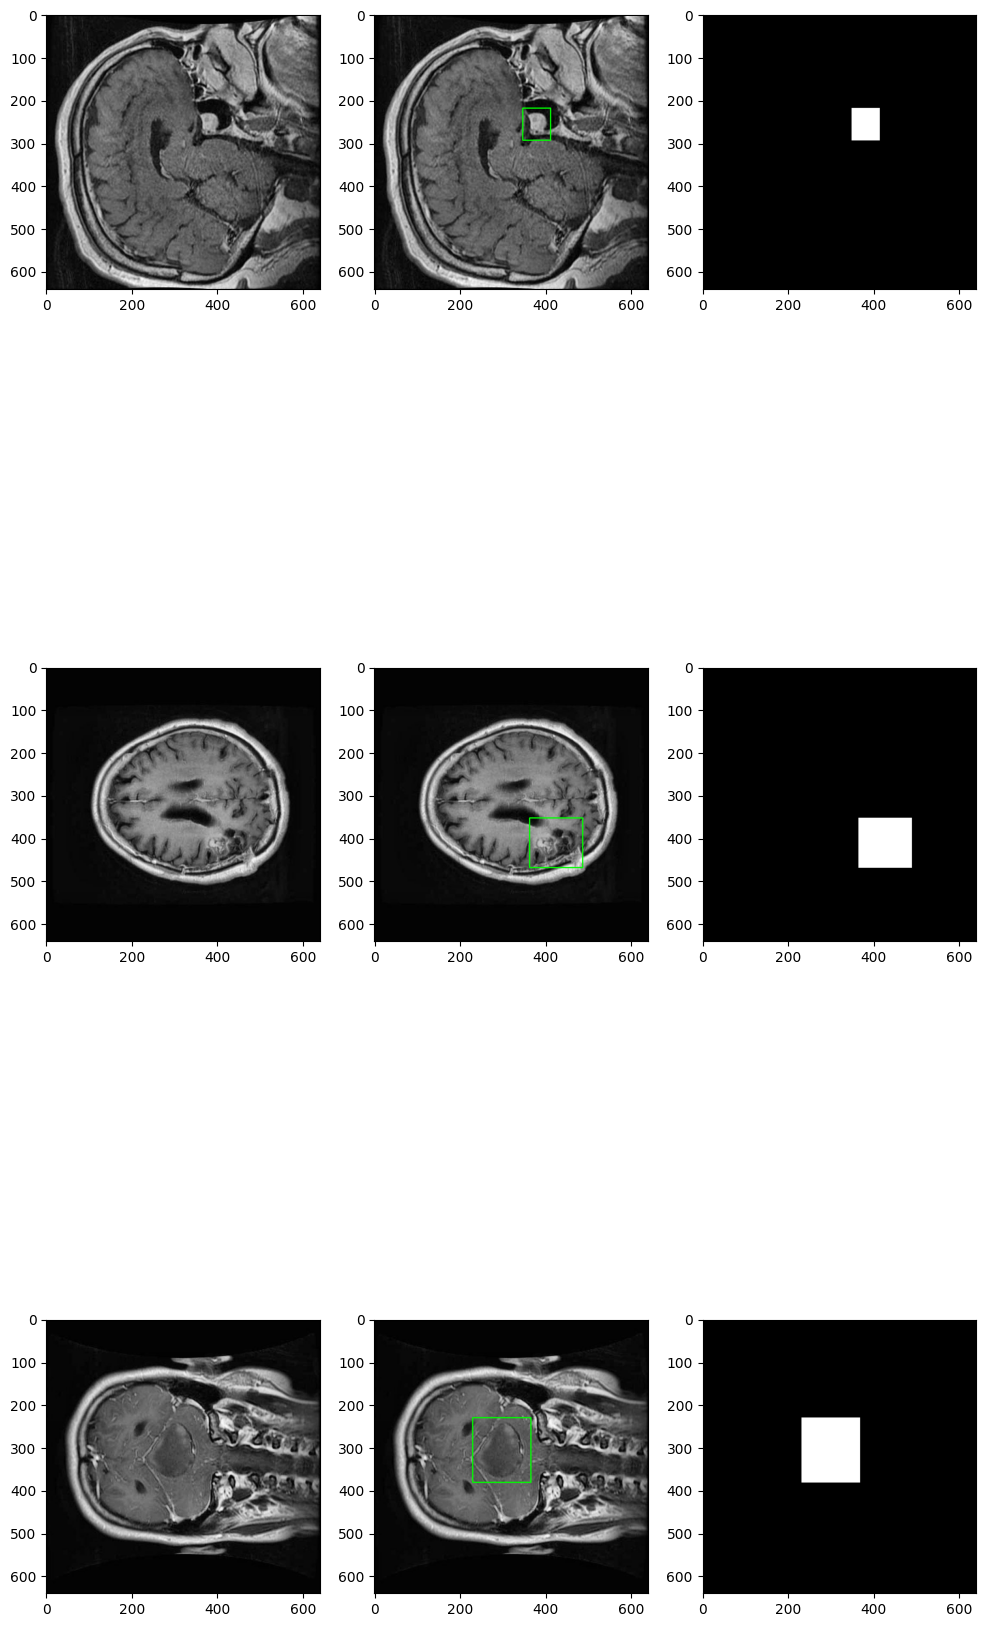

In [14]:
visualize_random_images()

In [15]:
indices = np.random.randint(0, len(train_annotation['images']), size=3)
images = [train_annotation['images'][i] for i in indices]

###**Create Mask of each images**

In [16]:
for img, ann in zip(train_annotation['images'], train_annotation['annotations']):
        path = train_path + img['file_name']

In [17]:
path

'/content/brain-tumor-image-dataset-semantic-segmentation/train2711_jpg.rf.fe549a2c072487f2716ccf8ac3c867e6.jpg'

In [18]:
def create_masks(annotation, data_path, mask_dir, mask_type):
    print(f'Creating {mask_type} masks')
    os.makedirs(mask_dir, exist_ok=True)
    total_images = len(annotation['images'])
    done = 0

    for img, ann in zip(annotation['images'], annotation['annotations']):
        # Construct the full path
        path = os.path.join(data_path, img['file_name'])
        mask_path = os.path.join(mask_dir, img['file_name'])

        # Check if the file exists before loading
        if not os.path.exists(path):
            print(f"{mask_type.capitalize()} Image not found: {path}")
            continue

        # Load image in OpenCV
        image = cv2.imread(path)

        # Check if image was loaded successfully
        if image is None:
            print(f"Failed to load {mask_type} image: {path}. This could be due to an unsupported format or a corrupt file.")
            continue

        # Create the mask from segmentation
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255, 255, 255))
        cv2.imwrite(mask_path, mask)

        done += 1
        print(f"{mask_type.capitalize()} {done} / {total_images}")

In [19]:
def _train_masks():
    create_masks(train_annotation, train_path, '/content/brain-tumor-image-dataset-semantic-segmentation/train_masks/', 'train')

def _test_masks():
    create_masks(test_annotation, test_path, '/content/brain-tumor-image-dataset-semantic-segmentation/test_masks/', 'test')

def _val_masks():
    create_masks(valid_annotation, valid_path, '/content/brain-tumor-image-dataset-semantic-segmentation/val_masks/', 'validation')

In [20]:
from threading import Thread

def make_masks():
    threads = []
    threads.append(Thread(target=_train_masks))
    threads.append(Thread(target=_test_masks))
    threads.append(Thread(target=_val_masks()))

    for t in threads:
        t.start()
    for t in threads:
        t.join()

    print('Mask creation complete')

In [21]:
# Run the mask creation function
make_masks()

Creating validation masks
Validation 1 / 429
Validation 2 / 429
Validation 3 / 429
Validation 4 / 429
Validation 5 / 429
Validation 6 / 429
Validation 7 / 429
Validation 8 / 429
Validation 9 / 429
Validation 10 / 429
Validation 11 / 429
Validation 12 / 429
Validation 13 / 429
Validation 14 / 429
Validation 15 / 429
Validation 16 / 429
Validation 17 / 429
Validation 18 / 429
Validation 19 / 429
Validation 20 / 429
Validation 21 / 429
Validation 22 / 429
Validation 23 / 429
Validation 24 / 429
Validation 25 / 429
Validation 26 / 429
Validation 27 / 429
Validation 28 / 429
Validation 29 / 429
Validation 30 / 429
Validation 31 / 429
Validation 32 / 429
Validation 33 / 429
Validation 34 / 429
Validation 35 / 429
Validation 36 / 429
Validation 37 / 429
Validation 38 / 429
Validation 39 / 429
Validation 40 / 429
Validation 41 / 429
Validation 42 / 429
Validation 43 / 429
Validation 44 / 429
Validation 45 / 429
Validation 46 / 429
Validation 47 / 429
Validation 48 / 429
Validation 49 / 429
Val

###**Zipping all Masked Image**

In [22]:
import zipfile
import os

# Define the folder paths
folders = ['train_masks', 'test_masks', 'val_masks']

# Define the output zip file path
output_zip = '/content/brain-tumor-image-dataset-semantic-segmentation/archive.zip'

# Create a Zip file and add folders to it
with zipfile.ZipFile('masks.zip', 'w') as zipf:
  for folder in folders:
    folder_path = os.path.join('/content/brain-tumor-image-dataset-semantic-segmentation/', folder)
    # Walk through each folder and add its files
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        arcname = os.path.relpath(file_path, '/content/brain-tumor-image-dataset-semantic-segmentation/')
        zipf.write(file_path, arcname)
print("Folders zipped successfully into archive.zip")

Folders zipped successfully into archive.zip


###**Load Masked Data**
- Load the data in numpy format.
- Less quality data. Total size is like 500 mb.
- If data is larger and larger, intialise data generators.
- KERAS IMAGE FROM DATASET.
- Resizing.
- INTIALISE generator for masks and then original images.

In [23]:
import os
import cv2
import numpy as np
import json
import glob

# Define paths
data_dir = '/content/brain-tumor-image-dataset-semantic-segmentation/'
mask_dir = '/content/brain-tumor-image-dataset-semantic-segmentation/'

train_image_dir = os.path.join(data_dir, 'train')
test_image_dir = os.path.join(data_dir, 'test')
val_image_dir = os.path.join(data_dir, 'valid')

train_mask_dir = os.path.join(mask_dir, 'train_masks')
test_mask_dir = os.path.join(mask_dir, 'test_masks')
val_mask_dir = os.path.join(mask_dir, 'val_masks')

# Target size for resizing images and masks
target_size = (256, 256)

# Load Annotation files (JSON format)
train_annotation_path = glob.glob(os.path.join(train_image_dir, '*.json'))[0]
test_annotation_path = glob.glob(os.path.join(test_image_dir, '*.json'))[0]
val_annotation_path = glob.glob(os.path.join(val_image_dir, '*.json'))[0]

# Load the JSON files
train_annotation = json.load(open(train_annotation_path))
test_annotation = json.load(open(test_annotation_path))
val_annotation = json.load(open(val_annotation_path))

In [24]:
def process_image(image_dir, annotation_data, mask_dir, target_size):
  "Function to load and process images and masks"
  X, y = [], []

  for image in annotation_data['images']:
    image_path = os.path.join(image_dir, image['file_name'])
    mask_path = os.path.join(mask_dir, image['file_name'])

    # Load image and mask with error handling
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
      print(f"Image Not Found or unable to load: {image_path}")
      continue

    if mask is None:
      print(f"Mask Not Found or unable to load: {mask_path}")
      continue

    # Resize image and mask
    img_resized = cv2.resize(img, target_size)
    mask_resized = cv2.resize(mask, target_size)

    # Normalize the image and masks
    X.append(img_resized)
    y.append(mask_resized)

  # Convert to numpy arrays
  X = np.array(X).astype('float32') / 255.0
  y = np.expand_dims(np.array(y).astype('float32') / 255.0, axis = -1)

  # Binary Masks
  y = (y > 0.5).astype(np.float32)
  return X, y

In [25]:
def load_data():
  "Load training and Validation data"
  X_train, y_train = process_image(train_image_dir, train_annotation, train_mask_dir, target_size)
  X_val, y_val = process_image(val_image_dir, valid_annotation, val_mask_dir, target_size)
  return X_train, y_train, X_val, y_val

In [26]:
def load_test_data():
    """Load test data"""
    X_test, y_test = process_image(test_image_dir, test_annotation, test_mask_dir, target_size)
    return X_test, y_test

In [27]:
# Load data
X_train, y_train, X_val, y_val = load_data()
X_test, y_test = load_test_data()

In [28]:
print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

Train shape: (1502, 256, 256, 3), (1502, 256, 256, 1)
Validation shape: (429, 256, 256, 3), (429, 256, 256, 1)
Test shape: (215, 256, 256, 3), (215, 256, 256, 1)


##**Function to create a convolutional block for the U-Net model**

In [29]:
def convolution_block(input_tensor, num_filters, kernel_size = 3, use_batch_norm = True):
    """
    Performs two convolution operations with optional batch normalization.

    Args:
        input_tensor (tensor): Input to the convolutional block.
        num_filters (int): Number of filters for the convolutional layers.
        kernel_size (int, optional): Size of the convolution kernel. Defaults to 3.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        tensor: Output after applying convolution, batch normalization, and activation.
    """
    # First convolution
    x = tf.keras.layers.Conv2D(num_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if use_batch_norm:
      x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Second Convolution
    x = tf.keras.layers.Conv2D(num_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer='he_normal', padding = 'same')(x)

    if use_batch_norm:
      x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

##**Function to create a U-Net model**

In [30]:
def build_unet(input_shape, num_filters = 16, dropout_rate = 0.1, use_batch_norm = True):
    """
    Builds a U-Net model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_filters (int, optional): Number of filters for the initial layer. Defaults to 16.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.1.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        keras.Model: Compiled U-Net model.
    """
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder Path
    c1 = convolution_block(inputs, num_filters * 1, use_batch_norm = use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolution_block(p1, num_filters * 2, use_batch_norm = use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolution_block(p2, num_filters * 4, use_batch_norm = use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolution_block(p3, num_filters * 8, use_batch_norm = use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = convolution_block(p4, num_filters * 16, use_batch_norm = use_batch_norm)

    # Decoder Path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    c6 = convolution_block(u6, num_filters * 8, use_batch_norm = use_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    c7 = convolution_block(u7, num_filters * 4, use_batch_norm = use_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    c8 = convolution_block(u8, num_filters * 2, use_batch_norm = use_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    c9 = convolution_block(u9, num_filters * 1, use_batch_norm = use_batch_norm)

    # Output Layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

    # Model Creation
    model = tf.keras.Model(inputs = [inputs], outputs = [output])
    return model

In [31]:
# Instantiate and compile the U-Net model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate = 0.07)
unet_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [33]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 25.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


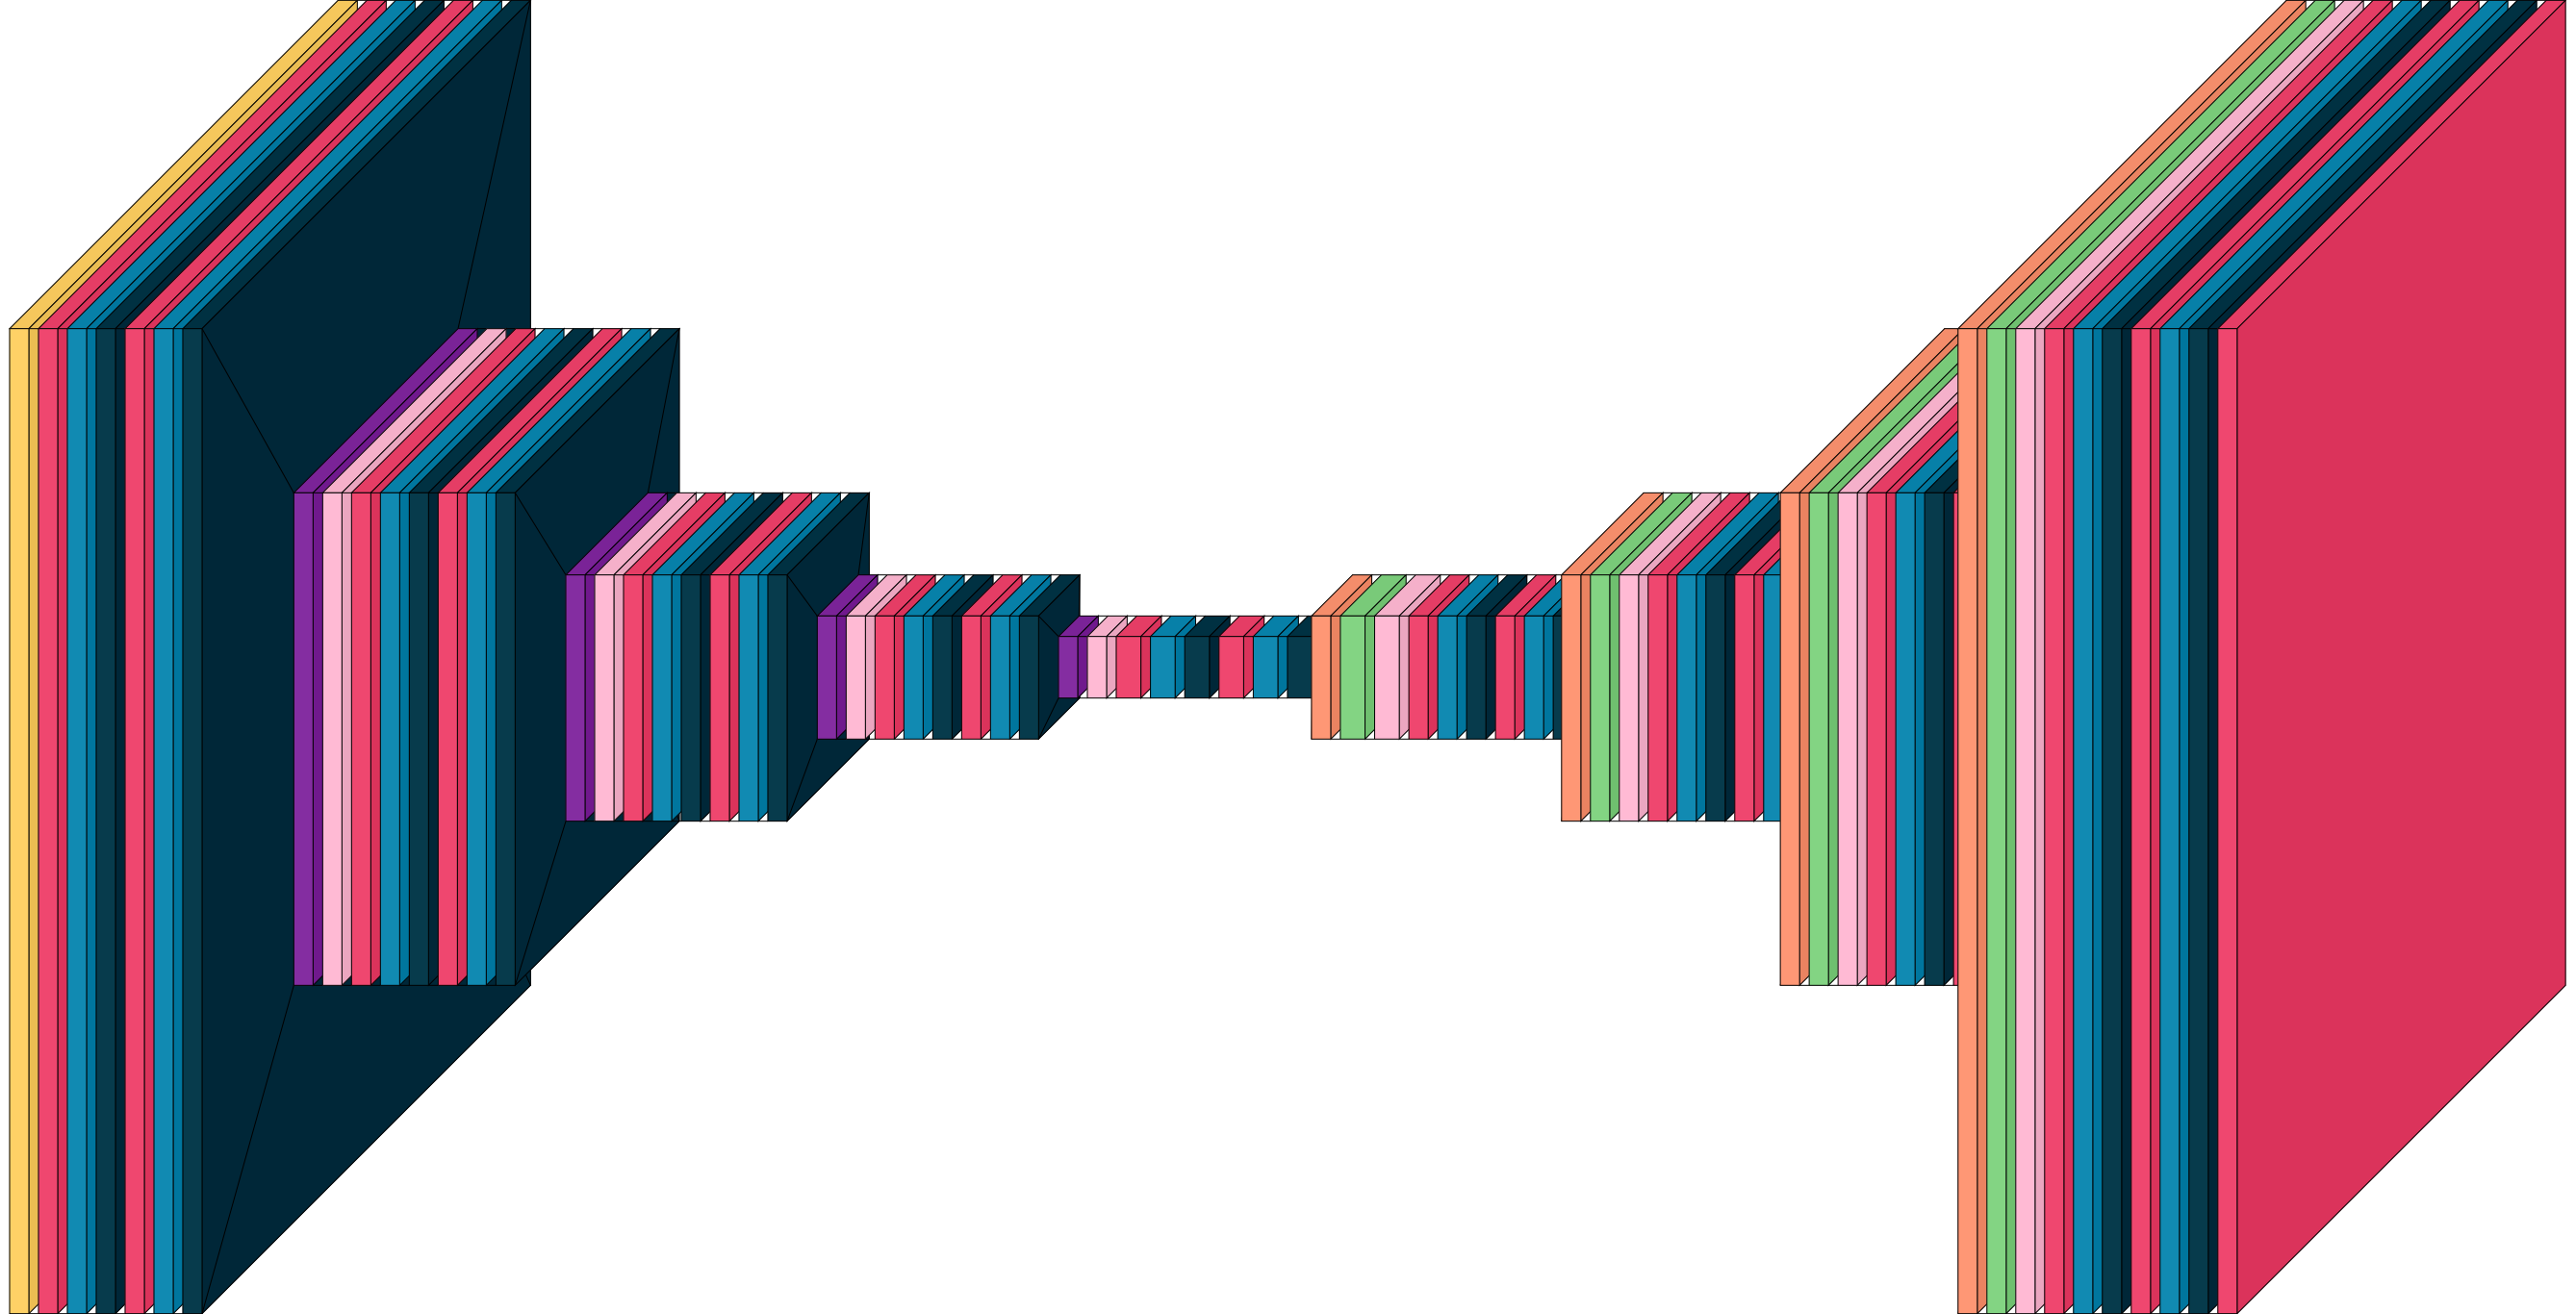

In [34]:
import visualkeras
from visualkeras import layered_view
visualkeras.layered_view(unet_model)

In [35]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('unet_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [36]:
# Train the model
history = unet_model.fit(X_train,
                         y_train,
                         validation_data=(X_val, y_val),
                         epochs=10,
                         verbose=1,
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8605 - loss: 0.4320   
Epoch 1: val_loss improved from inf to 1.78882, saving model to unet_model_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8618 - loss: 0.4300 - val_accuracy: 0.9625 - val_loss: 1.7888 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9627 - loss: 0.2002
Epoch 2: val_loss improved from 1.78882 to 0.22381, saving model to unet_model_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 333ms/step - accuracy: 0.9627 - loss: 0.2000 - val_accuracy: 0.9624 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9624 - loss: 0.1632
Epoch 3: val_loss did not improve from 0.22381
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.9624 - loss: 0.1631 - val_accuracy: 0.9077 - val_loss: 0.3240 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9635 - loss: 0.1388
Epoch 4: 

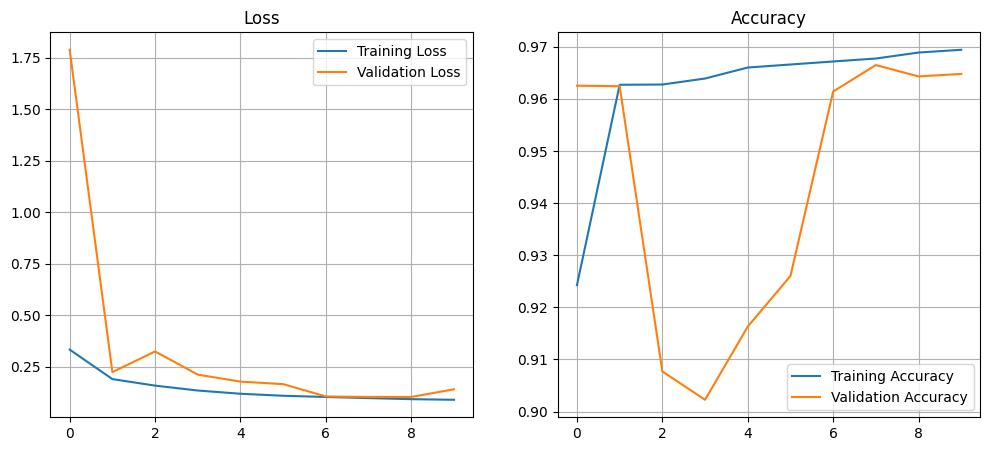

In [37]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.show()

In [38]:
# Function to predict and time the inference for a single image
def predict_single_image(image, model):
    """
    Predicts the segmentation mask for a single image and times the prediction.

    Args:
        image (array): Input image for prediction.
        model (keras.Model): Trained U-Net model.

    Returns:
        tuple: Predicted mask and inference time.
    """
    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time

    return prediction, inference_time

In [39]:
# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, and ground truth mask.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

In [40]:
# Example inference on a validation image
sample_image = X_test[0]
sample_ground_truth = y_test[0]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Inference time for a single image: 2.6668 seconds


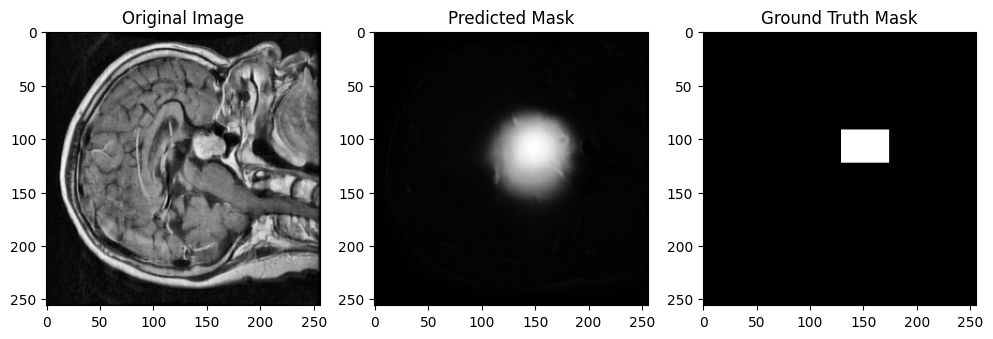

In [41]:
# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Inference time for a single image: 0.1188 seconds


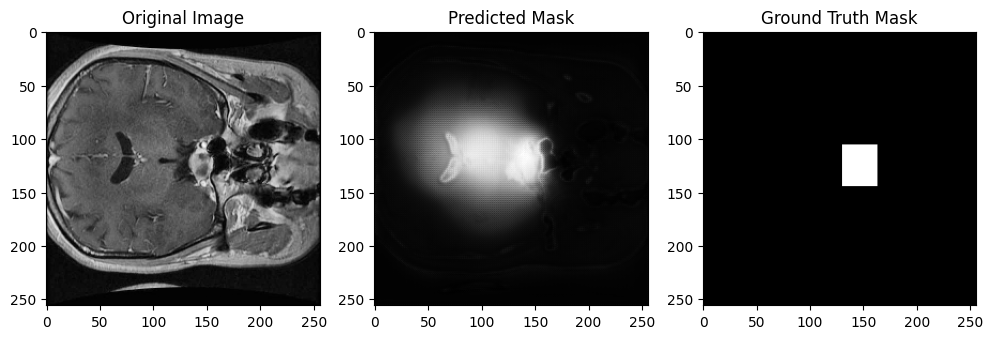

In [42]:
# Example inference on a validation image
sample_image = X_test[10]
sample_ground_truth = y_test[10]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

###**Adding IOU to the metrics while training Model**

In [43]:
EPOCHS = 50

In [44]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [45]:
# Get IOU for Training Data
y_pred = unet_model.predict(X_train)
print(mean_iou(y_train,y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step
tf.Tensor(0.17186162, shape=(), dtype=float32)


In [46]:
# Get IOU for Test Data
y_pred = unet_model.predict(X_test)
print(mean_iou(y_test,y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
tf.Tensor(0.19036977, shape=(), dtype=float32)


In [47]:
# Get IOU for Validation Data
y_pred = unet_model.predict(X_val)
print(mean_iou(y_val,y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
tf.Tensor(0.18973331, shape=(), dtype=float32)


In [48]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Dice coefficient score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [49]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [50]:
# Compile the U-Net model with Dice coefficient and mean IoU as metrics
unet_model.compile(optimizer='Adam', loss='binary_crossentropy',
                   metrics=['accuracy', dice_coefficient, mean_iou])

In [51]:
# Train the model with the additional metrics
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, verbose=1)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 766ms/step - accuracy: 0.8072 - dice_coefficient: 0.0740 - loss: 0.5038 - mean_iou: 0.0384 - val_accuracy: 0.9373 - val_dice_coefficient: 0.0794 - val_loss: 0.3783 - val_mean_iou: 0.0414
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.9618 - dice_coefficient: 0.0748 - loss: 0.2516 - mean_iou: 0.0388 - val_accuracy: 0.8657 - val_dice_coefficient: 0.0974 - val_loss: 0.4541 - val_mean_iou: 0.0512
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.9643 - dice_coefficient: 0.0833 - loss: 0.2022 - mean_iou: 0.0435 - val_accuracy: 0.9498 - val_dice_coefficient: 0.0773 - val_loss: 0.2852 - val_mean_iou: 0.0402
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.9646 - dice_coefficient: 0.1219 - loss: 0.1664 - mean_iou: 0.0650 - val_accuracy: 0.6762 - val_dice_coefficient: 0.1013 - val_loss: 0.5040 - val_mean_iou: 0.0533
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.9643 - dice_coeff

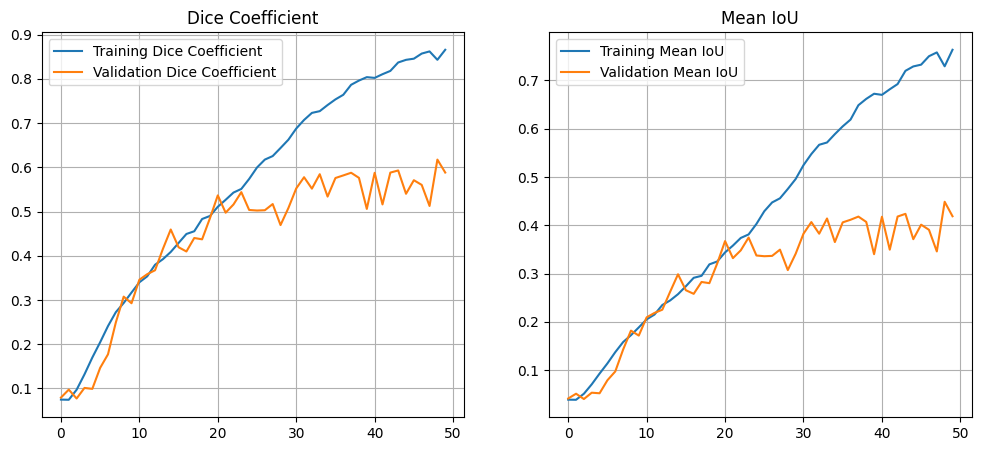

In [52]:
# Plot Dice coefficient and mean IoU during training and validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.grid()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.legend()
plt.grid()
plt.title('Mean IoU')

plt.show()

In [66]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, ground truth mask, and segmented image.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image

    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

In [69]:
# Example usage
sample_image = X_val[10]
sample_ground_truth = y_val[10]

predicted_mask, _ = predict_single_image(sample_image, unet_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


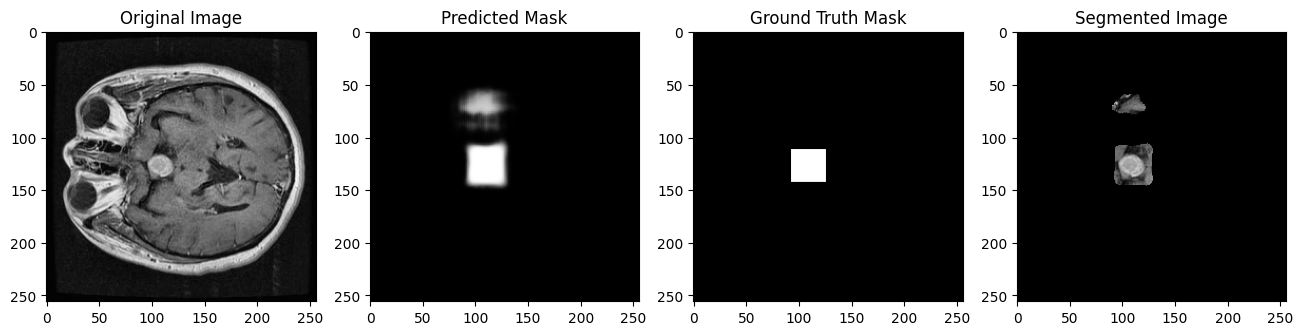

In [71]:
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


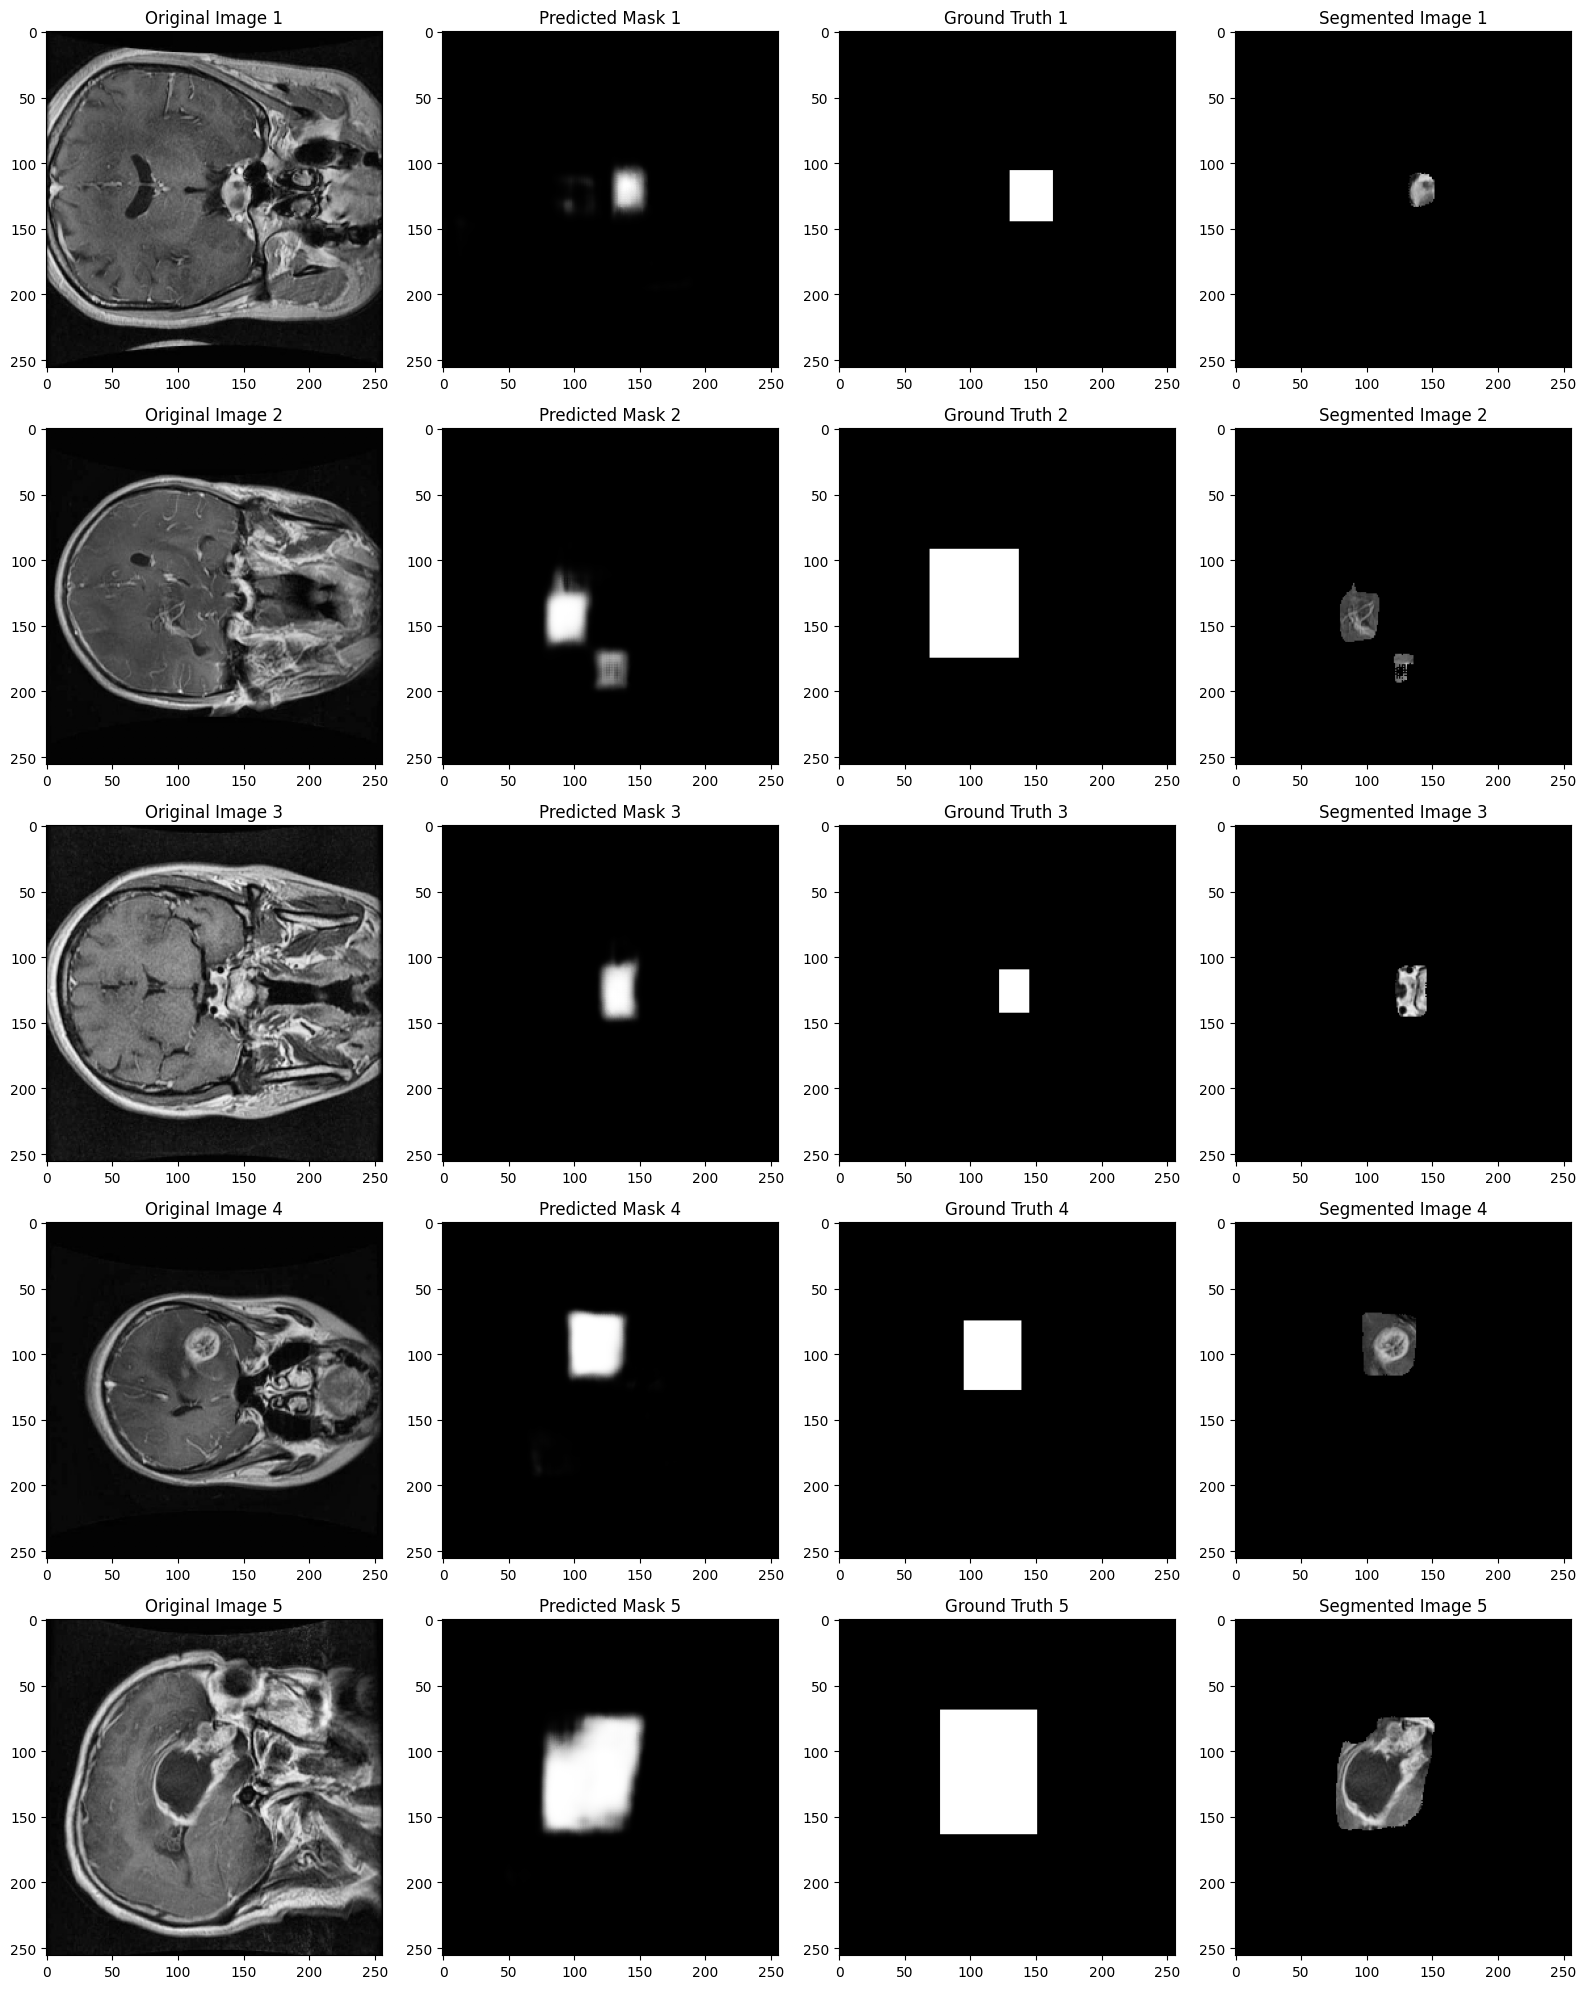

In [70]:
# Function to visualize multiple images with predictions and ground truths
def predict_and_visualize_multiple_images(images, model, ground_truth_masks):
    """
    Predicts masks for multiple images and visualizes the original images, predicted masks,
    and ground truth masks for all images side by side.

    Args:
        images (list): List of images for prediction.
        model (keras.Model): Trained U-Net model.
        ground_truth_masks (list): List of ground truth masks.
    """
    num_images = len(images)
    plt.figure(figsize=(16, num_images * 4))

    for i, image in enumerate(images):
        predicted_mask, inference_time = predict_single_image(image, model)

        # Plot Original Image
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(image)
        plt.title(f'Original Image {i+1}')

        # Plot Predicted Mask
        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title(f'Predicted Mask {i+1}')

        # Plot Ground Truth Mask
        plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(ground_truth_masks[i], cmap='gray')
        plt.title(f'Ground Truth {i+1}')

        # Plot Segmented Image (cropped with predicted mask)
        binary_mask = (predicted_mask > 0.5).astype(np.uint8)
        segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image
        plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(segmented_image)
        plt.title(f'Segmented Image {i+1}')

    plt.tight_layout()
    plt.show()

# Example usage with lists of images and masks
sample_images = [X_test[10], X_test[11], X_test[12], X_test[13], X_test[14]]  # Replace with actual images
sample_ground_truths = [y_test[10], y_test[11], y_test[12], y_test[13], y_test[14]]  # Replace with actual masks

predict_and_visualize_multiple_images(sample_images, unet_model, sample_ground_truths)